In [106]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import time
from skimage.data import binary_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fftn, ifftn, fftshift, ifftshift

from torchdiffeq import odeint, odeint_adjoint

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
method = 'dopri5'
adjoint = False
default_type = torch.float64
torch.set_default_dtype(default_type)

In [186]:
import sys, importlib
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

### Kuramoto

In [187]:
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2
       }
M = 5

kuramoto = Kuramoto(args, method)
kuramoto.init_state(M)
kuramoto.to(device)

T = 151
t = torch.linspace(0, T//2, T)
t0 = 50
T -= t0

kuramoto.solve(t)
kuramoto.trim(t0)

Elapsed time: 3.62 s


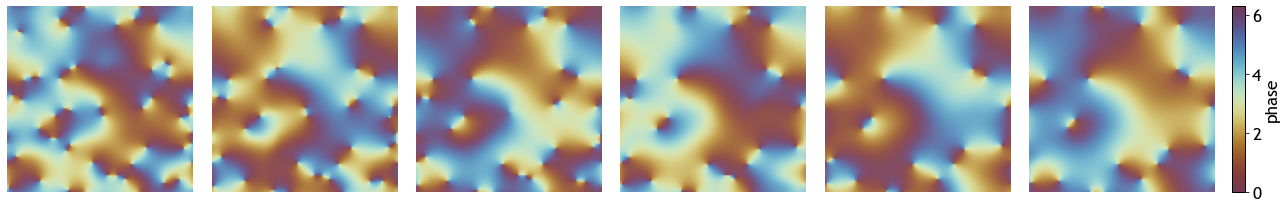

In [188]:
fig = kuramoto.plot_series(kuramoto.y[:,0].cpu().numpy().reshape(-1,kuramoto.N,kuramoto.N),
                           ntype='mod', clabel='phase')

### Gray-Scott

In [71]:
args = {'N': 200,
        'L': 2.,
        'Du': 1e-5,
        'Dv': 5e-6,
        'f': 0.040,
        'k': 0.063,
        'f0': 0.040,
        'k0': 0.060
       }
M = 1

grayscott = GrayScott(args, method)
grayscott.init_state(M)
grayscott.to(device)

tf = 2500
T = 6
t = torch.linspace(0, tf, T)

grayscott.init_solve(t)

Elapsed time: 11.56 s


In [74]:
tf = 250
T = 101
t = torch.linspace(0, tf, T)

grayscott.solve(t)

Elapsed time: 1.46 s


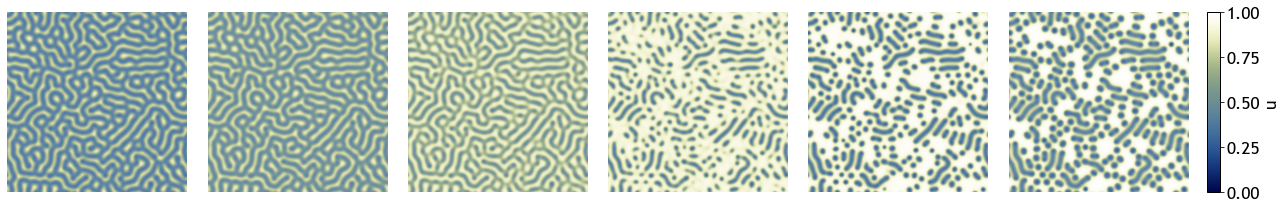

In [14]:
fig = grayscott.plot_series(grayscott.y[:,0,0].cpu().numpy().reshape(-1,grayscott.N,grayscott.N),
                            ntype='unit', clabel='u')

### Lotka-Volterra

In [79]:
args = {'N': 400,
        'L': 2.,
        'R': 0.07,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 10

lv = LotkaVolterra(args, method)
lv.init_state(M)
lv.to(device)

T = 151
t = torch.linspace(0, T-1, T)

lv.solve(t)

Elapsed time: 1.09 s


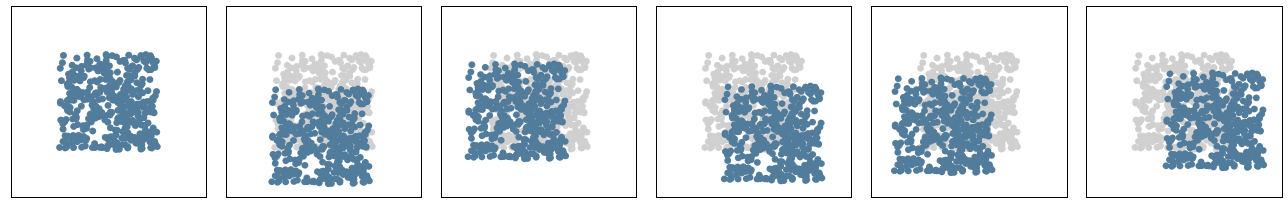

In [80]:
fig = lv.plot_series(lv.y[:,0].cpu().numpy())

In [157]:
niters = 500
test_freq = 10

In [408]:
class CXS(nn.Module):
    def __init__(self, n, L=1., dq=1., f_probe=None, f_mask=None):
        super(CXS, self).__init__()
        # TO DO:
        # - Passing in a real space probe as an argument, default to gaussian if not passed
        # - Handle complex probe (manually split into convolutions with real and imag parts of probe fft)
        
        self.L = L
        self.dq = dq
        self.f_probe = f_probe
        self.cmap = plt.cm.bone
        self.gmap = self.cmap.copy()
        self.gmap._lut[:self.gmap.N,3] = np.linspace(0, 0.7, self.gmap.N)[::-1]
        
        # Reciprocal-space coordinates
        self.q = 2*np.pi/L*torch.arange(-n/2., n/2., dq)
        self.n = len(self.q)
        Qx, Qy = torch.meshgrid(self.q, self.q, indexing='xy')
        self.Q = torch.stack((Qx.flatten(), Qy.flatten()), dim=1)
        
        if f_mask:
            self.mask = nn.Parameter((Qx**2 + Qy**2 > (f_mask*2*np.pi/L*self.n/2.)**2).flatten(), requires_grad=False)
        else:
            self.mask = 1.
        
        # Gaussian profile
        if f_probe:
            tol = 1e-16
            r_probe = f_probe*L
            k = 2*int(np.ceil(np.sqrt(-2*np.log(tol)/(r_probe**2))/(self.q.max() - self.q.min())*self.n)//2)
            k += 1 - self.n%2
            probe = torch.exp(-(self.Q**2).sum(dim=1)/(2./r_probe**2)).view((1,1,self.n,self.n))
            probe = self.center_crop(probe, k)
            self.probe = nn.Conv2d(1, 1, n, bias=False, padding='same', padding_mode='zeros')
            self.probe.weight = nn.Parameter(probe/probe.max(), requires_grad=False)
            
        else:
            self.probe = nn.Conv2d(1, 1, 1, bias=False, padding='same', padding_mode='zeros')
            self.probe.weight = nn.Parameter(torch.tensor(1.).view(1,1,1,1), requires_grad=False)

            
    def center_crop(self, y, k):
        # Crop the center kxk grid points of the array
        l = y.shape[-1]
        s = 1 - k%2
        return y[..., l//2 - k//2 + s:l//2 + k//2 + k%2 + s, l//2 - k//2 + s:l//2 + k//2 + k%2 + s]
    
    
    def plot_probe(self, ax):
        f_probe = self.f_probe if self.f_probe else 1.     
        _x = torch.arange(-self.L/2., self.L/2., self.L/100.)
        _X, _Y = np.meshgrid(_x, _x, indexing='xy')
        _r = np.stack((_X, _Y), axis=0)
        
        probe = np.exp((-(_r)**2).sum(axis=0)/(2.*(f_probe*self.L)**2))
        probe /= probe.max()
        
        sm = []
        sm.append(ax[0].imshow(probe, cmap=self.gmap, vmin=0., vmax=1.,
                               extent=(-self.L/2.,self.L/2.,-self.L/2.,self.L/2.), zorder=1))
        
        circles = [plt.Circle((0,0), radius=k*f_probe*self.L) for k in range(1,2)]
        c = mpl.collections.PatchCollection(circles, fc='none', ec='white', ls='dashed')
        ax[0].add_collection(c)
        
        sm.append(ax[1].imshow(self.probe.weight[0,0].cpu(), origin='lower', cmap=self.cmap, vmin=0, vmax=1))
        ax[1].axis('off')
        
        k = self.probe.weight.shape[-1]
        ax[1].text(0.9, 0.85, str(k) + r'$\times$' + str(k), color='white', ha='right', va='center',
                   transform=ax[1].transAxes, fontproperties=props)
        return sm
    
    
class CXSGrid(CXS):
    def __init__(self, N, n, L=1., dq=1., f_probe=None, f_mask=None, f='unit'):
        super(CXSGrid, self).__init__(n, L, dq, f_probe, f_mask)
        
        self.N = N
        
        # Real-space grid
        x = torch.arange(-L/2., L/2., L/N)
        X, Y = torch.meshgrid(x, x, indexing='xy')
        r = torch.stack((X.flatten(), Y.flatten()), dim=1)
        self.arg = nn.Parameter(torch.matmul(r, self.Q.transpose(1,0)), requires_grad=False)
        
        if f not in ['phase', 'unit']:
            self.f = getattr(self, 'f_unit')
        else:
            self.f = getattr(self, 'f_' + f)
            
            
    def f_phase(self, y, pol=1.):
        return 1. + pol*torch.cos(y)
        
        
    def f_unit(self, y, pol=1.):
        return y
            
        
    def forward(self, y, pol=1):
        y_real = torch.matmul(self.f(y, pol), torch.cos(self.arg))
        y_imag = torch.matmul(self.f(y, pol), torch.sin(self.arg))

        # Sum over concentration dimension?
        #y_real = y_real.mean(dim=-2)
        #y_imag = y_imag.mean(dim=-2)

        # Convolve with probe
        size = y_real.shape
        y_real = self.probe(y_real.view(-1,1,self.n,self.n)).view(*size)
        y_imag = self.probe(y_imag.view(-1,1,self.n,self.n)).view(*size)

        return (y_real**2 + y_imag**2)*self.mask
    
    
class CXSPoint(CXS):
    def __init__(self, R, n, L=1., dq=1., f_probe=None, f_mask=None):
        super(CXSPoint, self).__init__(n, L, dq, f_probe, f_mask)
        
        self.f = self.f_sphere(torch.sqrt((self.Q**2).sum(dim=1)), R)
    
    
    def f_sphere(self, q, R):
        V = 4./3.*np.pi*R**3
        f = V*torch.ones_like(q)
        f[q > 0.] = V*3*(torch.sin(q[q > 0.]*R) - q[q > 0.]*R*torch.cos(q[q > 0.]*R))/(q[q > 0.]*R)**3
        f /= f.max()
        return f
        
        
    def forward(self, y):
        arg = torch.matmul(y, self.Q.transpose(1,0))

        y_real = self.f*(torch.cos(arg).sum(dim=-2))
        y_imag = self.f*(torch.sin(arg).sum(dim=-2))
        
        # Convolve with probe
        size = y_real.shape
        y_real = self.probe(y_real.view(-1,1,self.n,self.n)).view(*size)
        y_imag = self.probe(y_imag.view(-1,1,self.n,self.n)).view(*size)
        
        return (y_real**2 + y_imag**2)*self.mask

### Kuramoto

In [409]:
n = 64
dq = 1.
f_probe = 0.2
cxs = CXSGrid(kuramoto.N, n, L=2., dq=dq, f_probe=f_probe, f_mask=None, f='phase').to(device)

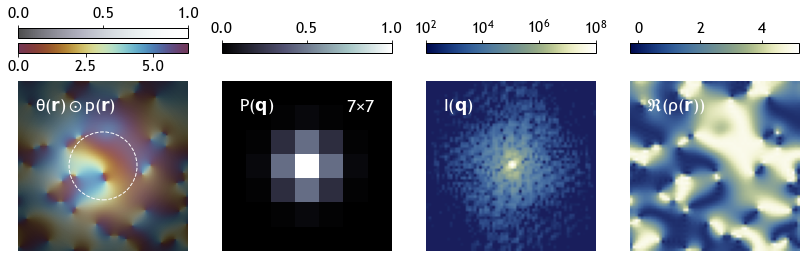

In [412]:
# Probe
fig, ax = plt.subplots(1,4, figsize=(14,3.5))
fig.subplots_adjust(wspace=0.2)

cax = []
for k in range(len(ax)):
    cax.append(fig.add_axes([ax[k].get_position().x0, ax[k].get_position().y1 + 0.07,
                             ax[k].get_position().width, 0.04]))
cax.insert(1, fig.add_axes([ax[0].get_position().x0, ax[0].get_position().y1 + 0.13,
                            ax[0].get_position().width, 0.04]))

sm = []
sm.append(kuramoto.plot_frame(ax[0], kuramoto.y0[0].reshape(kuramoto.N, kuramoto.N), ntype='mod'))
sm.extend(cxs.plot_probe(ax[:2]))
sm.append(kuramoto.plot_frame(ax[2], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                              vmin=1e2, vmax=1e8, ntype='log'))

# Real-space density field
f_real = torch.matmul(cxs.f(kuramoto.y0[0]), torch.cos(cxs.arg))
f_imag = torch.matmul(cxs.f(kuramoto.y0[0]), torch.sin(cxs.arg))
    
f = (f_real - 1j*f_imag).view(cxs.n,cxs.n)
p = np.real(ifftshift(ifftn(fftshift(f))))
vmax = p.abs().max()
sm.append(kuramoto.plot_frame(ax[3], p, alpha=0.9, extent=(-1./dq, 1./dq, -1./dq, 1./dq)))
ax[3].set_xlim(ax[0].get_xlim())
ax[3].set_ylim(ax[0].get_ylim())

cbar = []
cprops = props.copy()
cprops.set_size(props.get_size()-2)
for k in range(len(sm)):
    cbar.append(plt.colorbar(sm[k], cax=cax[k], orientation='horizontal'))
    if k > 0: cbar[k].ax.xaxis.set_ticks_position('top')
    format_axis(cbar[k].ax, cprops, xbins=3)
    
ax[0].text(0.1, 0.85, r'$\theta(\mathbf{r}) \odot p(\mathbf{r})$', color='white', ha='left', va='center',
           transform=ax[0].transAxes, fontproperties=props)

ax[1].text(0.1, 0.85, r'$P(\mathbf{q})$', color='white', ha='left', va='center',
           transform=ax[1].transAxes, fontproperties=props)

ax[2].text(0.1, 0.85, r'$I(\mathbf{q})$', color='white', ha='left', va='center',
           transform=ax[2].transAxes, fontproperties=props)

ax[3].text(0.1, 0.85, r'$\Re(\rho(\mathbf{r}))$', color='white', ha='left', va='center',
           transform=ax[3].transAxes, fontproperties=props);

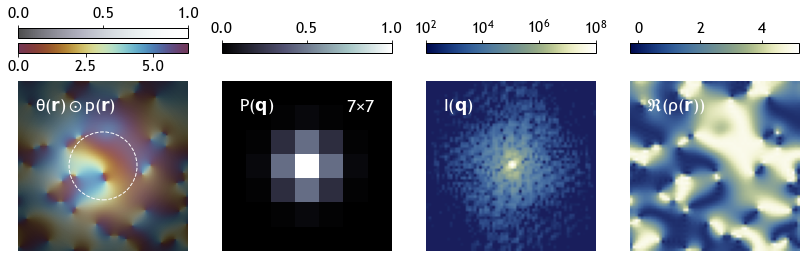

In [386]:
# Probe
fig, ax = plt.subplots(1,4, figsize=(14,3.5))
fig.subplots_adjust(wspace=0.2)

cax = []
for k in range(len(ax)):
    cax.append(fig.add_axes([ax[k].get_position().x0, ax[k].get_position().y1 + 0.07,
                             ax[k].get_position().width, 0.04]))
cax.insert(1, fig.add_axes([ax[0].get_position().x0, ax[0].get_position().y1 + 0.13,
                            ax[0].get_position().width, 0.04]))

sm = []
sm.append(kuramoto.plot_frame(ax[0], kuramoto.y0[0].reshape(kuramoto.N, kuramoto.N), ntype='mod'))
sm.extend(cxs.plot_probe(ax[:2]))
sm.append(kuramoto.plot_frame(ax[2], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                              vmin=1e2, vmax=1e8, ntype='log'))

# Real-space density field
f_real = torch.matmul(cxs.f(kuramoto.y0[0]), torch.cos(cxs.arg))
f_imag = torch.matmul(cxs.f(kuramoto.y0[0]), torch.sin(cxs.arg))
    
f = (f_real - 1j*f_imag).view(cxs.n,cxs.n)
p = np.real(ifftshift(ifftn(fftshift(f))))
vmax = p.abs().max()
sm.append(kuramoto.plot_frame(ax[3], p, alpha=0.9, extent=(-1./dq, 1./dq, -1./dq, 1./dq)))
ax[3].set_xlim(ax[0].get_xlim())
ax[3].set_ylim(ax[0].get_ylim())

cbar = []
cprops = props.copy()
cprops.set_size(props.get_size()-2)
for k in range(len(sm)):
    cbar.append(plt.colorbar(sm[k], cax=cax[k], orientation='horizontal'))
    if k > 0: cbar[k].ax.xaxis.set_ticks_position('top')
    format_axis(cbar[k].ax, cprops, xbins=3)
    
ax[0].text(0.1, 0.85, r'$\theta(\mathbf{r}) \odot p(\mathbf{r})$', color='white', ha='left', va='center',
           transform=ax[0].transAxes, fontproperties=props)

ax[1].text(0.1, 0.85, r'$P(\mathbf{q})$', color='white', ha='left', va='center',
           transform=ax[1].transAxes, fontproperties=props)

ax[2].text(0.1, 0.85, r'$I(\mathbf{q})$', color='white', ha='left', va='center',
           transform=ax[2].transAxes, fontproperties=props)

ax[3].text(0.1, 0.85, r'$\Re(\rho(\mathbf{r}))$', color='white', ha='left', va='center',
           transform=ax[3].transAxes, fontproperties=props);

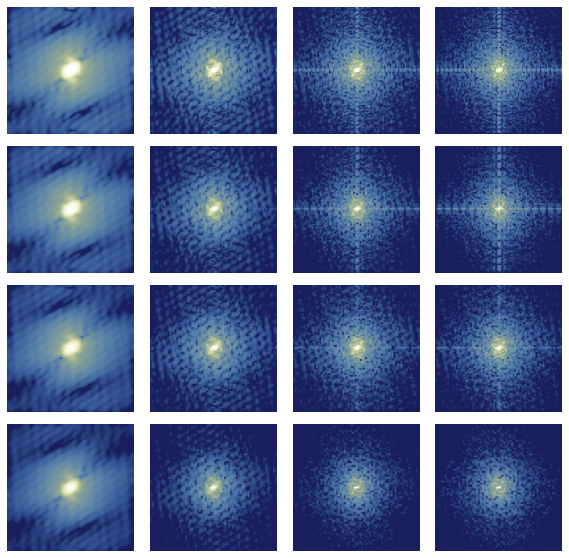

In [367]:
n = 64
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.1,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSGrid(kuramoto.N, n, L=2., dq=dq, f_probe=f_probe, f_mask=None, f='phase').to(device)
        kuramoto.plot_frame(ax[i,j], cxs(kuramoto.y[10,0], pol=1).reshape(cxs.n, cxs.n),
                            vmin=1e2, vmax=1e8, ntype='log')

In [347]:
batch_time = 20
batch_size = 2
batch_t, batch_y0, batch_y = kuramoto.get_batch(batch_time, batch_size)
print(' t:', batch_t.shape)
print('y0:', batch_y0.shape)
print(' y:', batch_y.shape)

 t: torch.Size([20])
y0: torch.Size([2, 1, 10000])
 y: torch.Size([20, 2, 1, 10000])


In [353]:
n = 64
dq = 0.8
f_probe = 0.1
cxs = CXSGrid(kuramoto.N, n, L=2., dq=dq, f_probe=f_probe, f_mask=None, f='phase').to(device)

In [357]:
print(cxs.probe.weight.shape)

torch.Size([1, 1, 19, 19])


In [358]:
cxs(batch_y)
ti = time.time()
batch_Y = cxs(batch_y, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

Elapsed time: 0.376 s


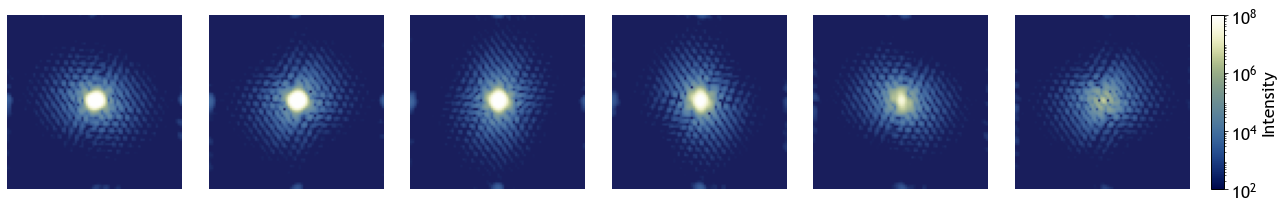

In [362]:
kuramoto.plot_series(batch_Y[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                     ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity');

### Gray-Scott

### Lotka-Volterra

In [358]:
n = 80
dq = 0.8
cxs = CXSPoint(lv.R, n, L=grayscott.L, dq=dq, f_probe=0.15, f_mask=None).to(device)
f = (cxs.f*(torch.exp(-1j*torch.matmul(lv.y0[0], cxs.Q.transpose(1,0))).sum(dim=0))).view(cxs.n,cxs.n)

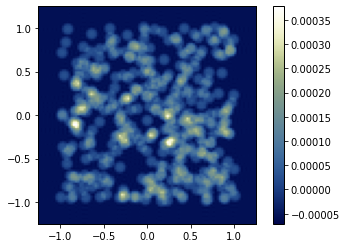

In [362]:
p = np.real(ifftshift(ifftn(fftshift(f))))
vmax = p.abs().max()
plt.imshow(p, origin='lower', cmap=cm.cork, extent=[-1./dq, 1./dq, -1./dq, 1./dq])
plt.colorbar()

In [ ]:
gmap = mpl.colors.LinearSegmentedColormap.from_list('gmap', [(1,1,1,0), cmap(100)])
x = np.arange(-L/2.,L/2.,L/N)
X, Y = np.meshgrid(x, x, indexing='xy')
rr = np.stack((X,Y), axis=0)

fig, ax = plt.subplots(figsize=(18,2))
circles = [plt.Circle((xi,yi), radius=d) for xi,yi in th[10,0]]
c = mpl.collections.PatchCollection(circles, lw=0, color='#D0D0D0', ec='#B0B0B0')
ax.add_collection(c)
g = ax.imshow(np.exp((-(rr)**2).sum(axis=0)/(2.*s**2)), cmap=gmap, extent=(-L/2.,L/2.,-L/2.,L/2.), zorder=N+1)
plt.colorbar(g)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2]);

In [ ]:
method = 'dopri5'
adjoint = False